<a href="https://colab.research.google.com/github/shubhamguptasr/drowsinessDetection/blob/ashish/Greenwood_Drowsiness_Detection_v16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **MRL Dataset for Open/Close Eyes Detection using CNNs**
Publicly available large-scale data set of open and closed eyes, containing infrared images in low and high resolution, all captured in various lighting conditions and by different devices. An eye detector SVM classifier was used to obtain these eye images and create the MRL dataset. 
Dataset source: http://mrl.cs.vsb.cz/eyedataset

We train, validate and test out a series of CNN models (with different architectures and using transfer learning in some cases) to try and get the highest accuracy and F1score on the algorithm recognizing whether the image is of an open or closed eye. 5 models are shared below. 

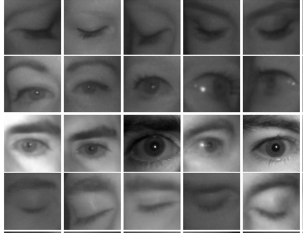


In [1]:
!pip install GPUtil -q
!pip install psutil -q
!pip install git+https://github.com/tensorflow/docs -q
!pip install efficientnet -q


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.3 MB/s eta 0:00:00


In [2]:
import os
import shutil
from numba import jit, cuda

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import keras
import efficientnet.keras as efn

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, AveragePooling2D, Dropout, Flatten, Conv2D, MaxPooling2D, AvgPool2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop


from keras.models import Model
from keras import metrics
from keras import optimizers
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from GPUtil import showUtilization as gpu_usage
from  IPython import display
from matplotlib import pyplot as plt
from timeit import default_timer as timer
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau
from keras.optimizers import Adam 

import pathlib
import shutil
import tempfile

### Delete folders to clean up existing data to enable multiple code run-all executions in Google Colab.

In [3]:
def cleanup(dirpath):
  if os.path.exists(dirpath) and os.path.isdir(dirpath):
    shutil.rmtree(dirpath)

cleanup('/content/dataset')
cleanup('/content/test')

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

### **Download eye dataset and partition in 2 directories (dataset and test)**

In [5]:
#Download the MRL eye data set
!wget http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip
!unzip -o -q mrlEyes_2018_01.zip

--2023-04-09 21:19:05--  http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip
Resolving mrl.cs.vsb.cz (mrl.cs.vsb.cz)... 158.196.141.22
Connecting to mrl.cs.vsb.cz (mrl.cs.vsb.cz)|158.196.141.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341866898 (326M) [application/zip]
Saving to: ‘mrlEyes_2018_01.zip’

mrlEyes_2018_01.zip 100%[===================>] 326.03M  7.12MB/s    in 48s     

2023-04-09 21:19:57 (6.75 MB/s) - ‘mrlEyes_2018_01.zip’ saved [341866898/341866898]



In [6]:
# Define the path to the directory where the files were extracted
directory = '/content/mrlEyes_2018_01'

# Define the path to the "dataset" folder
dataset_dir = '/content/dataset'

# Create new folders named "open", "closed", and "invalid" inside the "dataset" folder
os.makedirs(os.path.join(dataset_dir, 'open'), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, 'closed'), exist_ok=True)
#os.makedirs(os.path.join(dataset_dir, 'invalid'), exist_ok=True)

# Loop through all files in the directory
for folder in os.listdir(directory):
    # Get the path to the current folder
    folder_path = os.path.join(directory, folder)

    # Check if the current item in the directory is a folder
    if os.path.isdir(folder_path):
        # Loop through all files in the folder
        for filename in os.listdir(folder_path):
            # Check if the file is a PNG image
            if filename.endswith(".png"):
                # Get the 16th character of the filename
                label = filename[16]
                src_path = os.path.join(folder_path, filename)
                # Determine if the image is open or closed
                if label == "0":
                    # Move the file to the "closed" folder
                    dst_path = os.path.join(dataset_dir, 'closed', filename)
                elif label == "1":
                    # Move the file to the "open" folder
                    dst_path = os.path.join(dataset_dir, 'open', filename)
                shutil.move(src_path, dst_path)

### MRIL data and split into training+validation (dataset) and test directories shows balanced data (~roughly even close and open images)

In [7]:
# Define the path to the "test" folder
test_dir = '/content/test'

# Create new folders named "open", "closed", and "invalid" inside the "test" folder
os.makedirs(os.path.join(test_dir, 'open'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'closed'), exist_ok=True)

# Loop through all files in the "closed" folder
for filename in os.listdir(os.path.join(dataset_dir, 'closed')):
    # Move 15% of the files to the "closed" folder in the "test" directory
    if np.random.rand() < 0.15:
        src_path = os.path.join(dataset_dir, 'closed', filename)
        dst_path = os.path.join(test_dir, 'closed', filename)
        shutil.move(src_path, dst_path)

# Loop through all files in the "open" folder
for filename in os.listdir(os.path.join(dataset_dir, 'open')):
    # Move 15% of the files to the "open" folder in the "test" directory
    if np.random.rand() < 0.15:
        src_path = os.path.join(dataset_dir, 'open', filename)
        dst_path = os.path.join(test_dir, 'open', filename)
        shutil.move(src_path, dst_path)

In [8]:
# Define the path to the "closed" folder
closed_folder = '/content/dataset/closed'

# Count the total number of PNG files in the "closed" folder
num_png_files = len([f for f in os.listdir(closed_folder) if f.endswith('.png')])

# Print the total number of PNG files in the "closed" folder
print("Total number of PNG files in 'closed' folder:", num_png_files)
     

Total number of PNG files in 'closed' folder: 35678


In [9]:
# Define the path to the "open" folder
open_folder = '/content/dataset/open'

# Count the total number of PNG files in the "open" folder
num_png_files = len([f for f in os.listdir(open_folder) if f.endswith('.png')])

# Print the total number of PNG files in the "open" folder
print("Total number of PNG files in open' folder:", num_png_files)

Total number of PNG files in open' folder: 36583


In [10]:
# Define the path to the "closed" folder
closed_folder = '/content/test/closed'

# Count the total number of PNG files in the "closed" folder
num_png_files = len([f for f in os.listdir(closed_folder) if f.endswith('.png')])

# Print the total number of PNG files in the "closed" folder
print("Total number of PNG files in 'closed' test folder:", num_png_files)

Total number of PNG files in 'closed' test folder: 6268


In [11]:
# Define the path to the "open" folder
open_folder = '/content/test/open'

# Count the total number of PNG files in the "open" folder
num_png_files = len([f for f in os.listdir(open_folder) if f.endswith('.png')])

# Print the total number of PNG files in the "open" folder
print("Total number of PNG files in open' test folder:", num_png_files)

Total number of PNG files in open' test folder: 6369


###Check for duplicates between open and closed folders in dataset directory

In [12]:
!diff -srq /content/dataset/closed/ /content/dataset/open/ | grep identicalfile

In [13]:
!file /content/dataset/closed/s0001_00001_0_0_0_0_0_01.png

/content/dataset/closed/s0001_00001_0_0_0_0_0_01.png: PNG image data, 86 x 86, 8-bit grayscale, non-interlaced


### **Exploratory Data Analysis**

Found 72261 files belonging to 2 classes.
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)
(86, 86, 3)


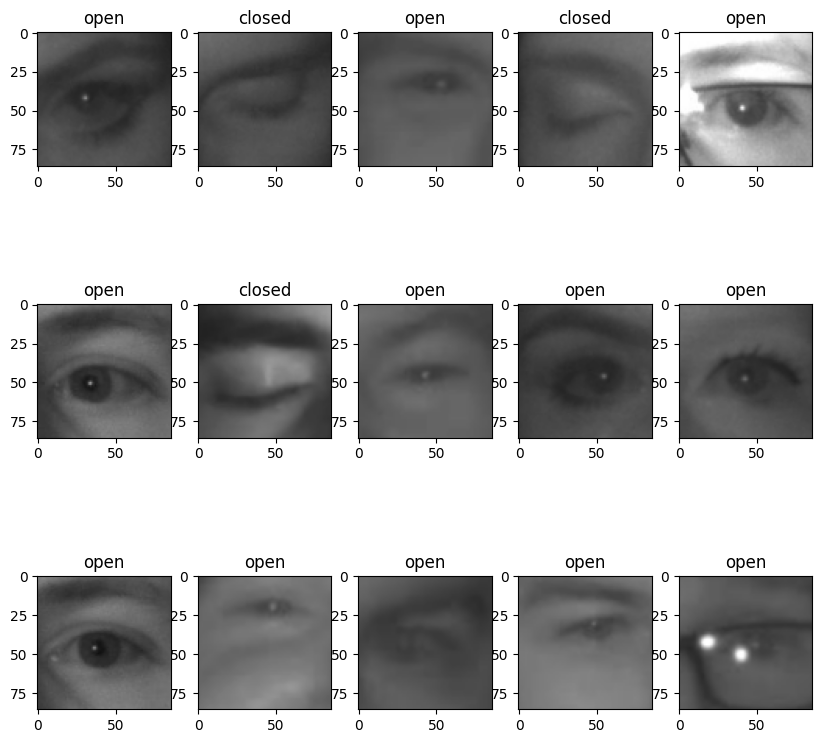

In [14]:
IMAGE_SIZE=86
BATCH_SIZE=32
CHANNELS=3

edacheck = tf.keras.preprocessing.image_dataset_from_directory("dataset", shuffle="True",image_size= (IMAGE_SIZE,IMAGE_SIZE), batch_size=BATCH_SIZE)
class_names = edacheck.class_names
class_names

plt.figure(figsize=(10,10))
for image_batch, label_batch in edacheck.take(1):
  for i in range(15):
    ax=plt.subplot(3,5,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    print(image_batch[i].shape)


### **Data Augmentation, Resizing/Rescaling, Splitting dataset directory into training and validation data**

In [15]:
train_valdatagen = ImageDataGenerator(rescale=1/255,rotation_range=7,horizontal_flip=True,validation_split=0.18)

train_generator = train_valdatagen.flow_from_directory(directory = "dataset",target_size=(86,86), batch_size=32, class_mode='categorical', subset='training',shuffle=True)

validation_generator =  train_valdatagen.flow_from_directory(directory = "dataset",target_size=(86,86), batch_size=32, class_mode='categorical', subset='validation',shuffle=True)

test_generator= ImageDataGenerator(rescale=1/255.0,).flow_from_directory(directory = "test", target_size=(86,86), batch_size = 32, class_mode = 'categorical',shuffle = False)


Found 59255 images belonging to 2 classes.
Found 13006 images belonging to 2 classes.
Found 12637 images belonging to 2 classes.


### **Model Building: Creating standardized functions for training, validation, model fitting and inference (including setting up tuning parameters such as learning rate schedule with decay and callbacks)**

In [16]:
#Setting the initial set of vaiables for all the models
N_VALIDATION = validation_generator.n
N_TRAIN = train_generator.n
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*10,
  decay_rate=1,
  staircase=False)

#Function to get the optimizers
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

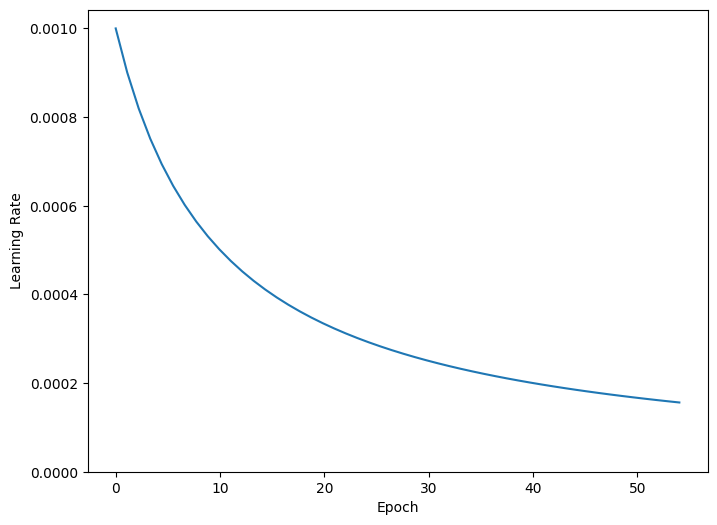

In [17]:
#Printing the learning rate schedule
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [18]:
#Function to get the callbacks
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_categorical_crossentropy', patience=10, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(logdir/name),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.0001)
  ]

In [19]:
#Function to compile and train the models
def compile_and_fit(m, name, train_ds, validate_ds, loss, metrics, optimizer=None, max_epochs=50):
  if optimizer is None:
    optimizer = get_optimizer()
  if loss is None:
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
  if metrics is None:
    metrics= [tf.keras.metrics.CategoricalCrossentropy(from_logits=False, name='categorical_crossentropy'),'accuracy', 'AUC']

  m.compile(optimizer=optimizer,loss=loss, metrics=metrics)

  m.summary()

  history = m.fit(train_ds,steps_per_epoch = 10, epochs=max_epochs,validation_data=validate_ds, callbacks=get_callbacks(name),verbose=1)
  
  return history

In [20]:
#Function to predict the  individual image using the model
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)

  return predicted_class, confidence

In [21]:
#Function to predict the set of images using the models
def predict_test_images(m):
  edacheck = tf.keras.preprocessing.image_dataset_from_directory("test", shuffle="True",image_size= (86,86), batch_size=BATCH_SIZE)
  class_names = edacheck.class_names

  plt.figure(figsize=(10, 10))
  for images, labels in edacheck.take(1):
    for i in range(4):
      ax = plt.subplot(1, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      
      predicted_class, confidence = predict(m, images[i].numpy())
      actual_class = class_names[labels[i]] 
      
      plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
      
      plt.axis("off")

In [22]:
#Function to evaluate and predict the model performance
def evaluate_and_predict(m, test_ds):

  loss, cat_x_entropy, accuracy, auc = m.evaluate(test_ds)
  print('Test set loss                    : {:.4f}'.format(loss))
  print('Test set categorical_crossentropy: {:.4f}'.format(cat_x_entropy))
  print('Test set accuracy                : {:.4f}'.format(accuracy))
  print('Test set auc                     : {:.4f}'.format(auc))
  # Make predictions on the test data using the trained model
  predictions=m.predict(test_ds)

  # Get the predicted labels (0 or 1) by finding the index of the maximum value in each prediction
  predicted_labels=np.argmax(predictions,axis=1)

  # Get the true labels from the test data generator
  true_labels=test_ds.classes
  # Get the class names (open or closed) from the test data generator
  class_names=list(test_ds.class_indices.keys())

  # Print the classification report and confusion matrix
  print("Classification Report:")
  print(classification_report(true_labels,predicted_labels,target_names=class_names))
  print("\nConfusion Matrix:")
  # print(confusion_matrix(true_labels, predicted_labels))
  # Create the confusion matrix
  cm = confusion_matrix(true_labels, predicted_labels)

  # Create a heatmap of the confusion matrix
  sns.heatmap(cm, annot=True, cmap='BuGn', fmt='g', xticklabels=class_names, yticklabels=class_names)

  # Add labels and title
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix',fontweight="bold")

  # Show the plot
  plt.show()
  return 0

In [23]:
#Function to plot the graphs of individual models
def plot_loss_accuracy_cat_x_entropy(histories):
  plt.figure(figsize=(15, 5))
  plt.subplot(1, 3, 1)
  plotter = tfdocs.plots.HistoryPlotter(metric = 'categorical_crossentropy', smoothing_std=10)
  plotter.plot(histories)
  plt.ylim([0, 1])
  plt.subplot(1, 3, 2)
  plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
  plotter.plot(histories)
  plt.ylim([0, 1])
  plt.subplot(1, 3, 3)
  plotter = tfdocs.plots.HistoryPlotter(metric = 'auc', smoothing_std=10)
  plotter.plot(histories)
  plt.ylim([0, 1])
  return 0

In [24]:
#Function to plot the graphs of all the models
def plot_loss_accuracy_cat_x_entropy_all(histories):
  plt.figure(figsize=(15, 15))
  # plt.subplot(1, 3, 1)
  plotter = tfdocs.plots.HistoryPlotter(metric = 'categorical_crossentropy', smoothing_std=10)
  plotter.plot(histories)
  plt.ylim([0, 1])
  plt.figure(figsize=(15, 15))
  # plt.subplot(1, 3, 2)
  plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
  plotter.plot(histories)
  plt.ylim([0, 1])
  plt.figure(figsize=(15, 15))
  # plt.subplot(1, 3, 3)
  plotter = tfdocs.plots.HistoryPlotter(metric = 'auc', smoothing_std=10)
  plotter.plot(histories)
  plt.ylim([0, 1])
  return 0

In [25]:
#Function to test the saved models and get processing times and memory usage
def test_saved_models(m):
  print("\n-------Begin-------")
  gpu_usage()
  
  model_saved = load_model(m)

  # Make predictions on the test data using the trained model
  start = timer()
  predictions=model_saved.predict(test_generator)
  gpu_usage()
  print("-------Time taken to process images:", timer() - start)

  # Get the predicted labels (0 or 1) by finding the index of the maximum value in each prediction
  predicted_labels=np.argmax(predictions,axis=1)

  # Get the true labels from the test data generator
  true_labels=test_generator.classes

  # Get the class names (open or closed) from the test data generator
  class_names=list(test_generator.class_indices.keys())

  # Print the classification report and confusion matrix
  print("Classification Report:")
  print(classification_report(true_labels,predicted_labels,target_names=class_names))
  print("\nConfusion Matrix:")
  print(confusion_matrix(true_labels, predicted_labels))
  print("\n-------End-------")

In [26]:
#Total number of images
validation_generator.n +test_generator.n + train_generator.n

84898

In [27]:
# Set epochs for training for all models
epochs=50

### **1. CNN - Base Modelv0**
### (~1 conv layer + maxpooling, relu, ~88% Test Accuracy and F1-Score)




In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (86, 86,3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 2)                 56450     
                                                                 
Total params: 56,898
Trainable params: 56,898
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_histories = {}
model_histories['model_Modelv0'] = compile_and_fit(model,'model_Modelv0', 
                                                            train_generator, 
                                                            validation_generator,
                                                            loss= None, 
                                                            metrics= None, 
                                                            optimizer=None, 
                                                            max_epochs=epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 2)                 56450     
                                                                 
Total params: 56,898
Trainable params: 56,898
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 0.8638 - categorical_crossentropy: 0.8638 - accura

395/395 [==============================] - 7s 17ms/step - loss: 0.3321 - categorical_crossentropy: 0.3321 - accuracy: 0.8641 - auc: 0.9335
Test set loss                    : 0.3321
Test set categorical_crossentropy: 0.3321
Test set accuracy                : 0.8641
Test set auc                     : 0.9335
395/395 [==============================] - 7s 17ms/step
Classification Report:
              precision    recall  f1-score   support

      closed       0.80      0.96      0.87      6268
        open       0.95      0.77      0.85      6369

    accuracy                           0.86     12637
   macro avg       0.88      0.86      0.86     12637
weighted avg       0.88      0.86      0.86     12637


Confusion Matrix:


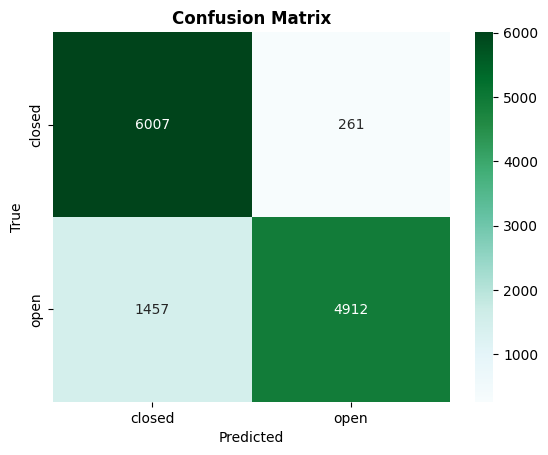

0

In [31]:
evaluate_and_predict(model, test_generator)

0

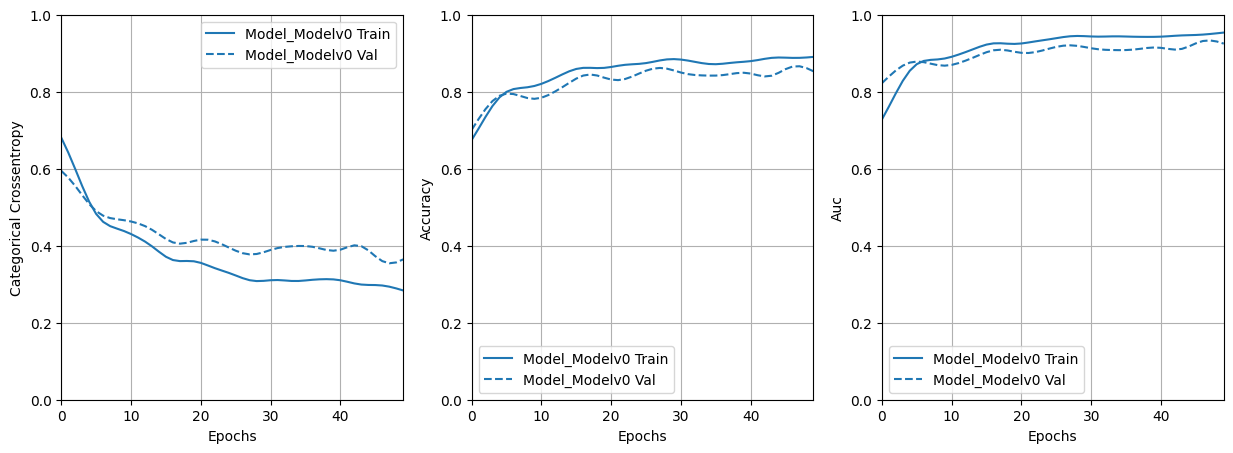

In [32]:
plot_loss_accuracy_cat_x_entropy(model_histories)

Found 12637 files belonging to 2 classes.
1/1 [==============================] - 0s 20ms/step


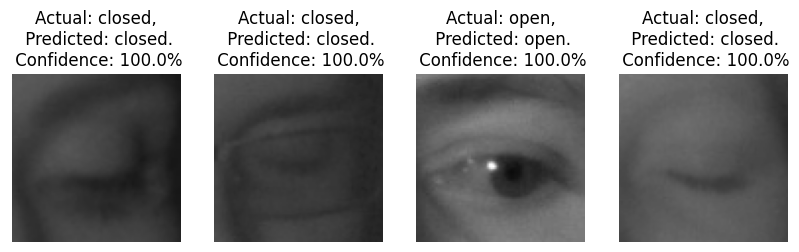

In [33]:
predict_test_images(model)

In [34]:
model.save('eyes_model_0.h5')
!ls -lh eyes_model_0.h5

-rw-r--r-- 1 root root 694K Apr  9 21:42 eyes_model_0.h5


In [35]:
models_list = []
models_list.append('eyes_model_0.h5')

### **2. CNN - Base Modelv1**
(~40 min training, 3 conv layers + maxpooling, relu, ~96% Test Accuracy and F1 Score)


In [36]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (86, 86, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [37]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 84, 84, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 9, 32)        

In [38]:
model_histories1 = {}
all_models = {}
model_histories1['model_Modelv1'] = compile_and_fit(model1,'model_Modelv1', 
                                                            train_generator, 
                                                            validation_generator,
                                                            loss= None, 
                                                            metrics= None, 
                                                            optimizer=None, 
                                                            max_epochs=epochs)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 84, 84, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 9, 32)        

395/395 [==============================] - 7s 18ms/step - loss: 0.3158 - categorical_crossentropy: 0.3158 - accuracy: 0.8716 - auc: 0.9393
Test set loss                    : 0.3158
Test set categorical_crossentropy: 0.3158
Test set accuracy                : 0.8716
Test set auc                     : 0.9393
395/395 [==============================] - 7s 17ms/step
Classification Report:
              precision    recall  f1-score   support

      closed       0.89      0.84      0.87      6268
        open       0.85      0.90      0.88      6369

    accuracy                           0.87     12637
   macro avg       0.87      0.87      0.87     12637
weighted avg       0.87      0.87      0.87     12637


Confusion Matrix:


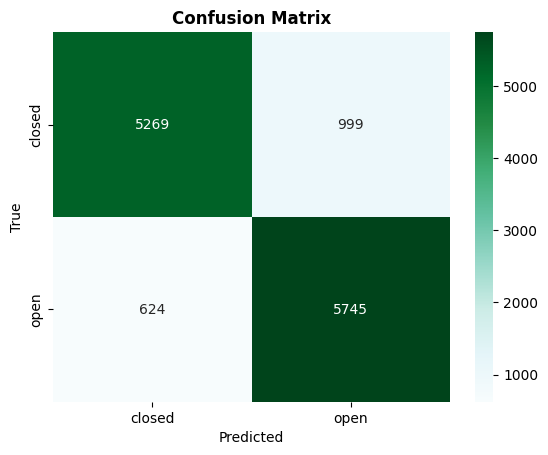

0

In [39]:
evaluate_and_predict(model1, test_generator)

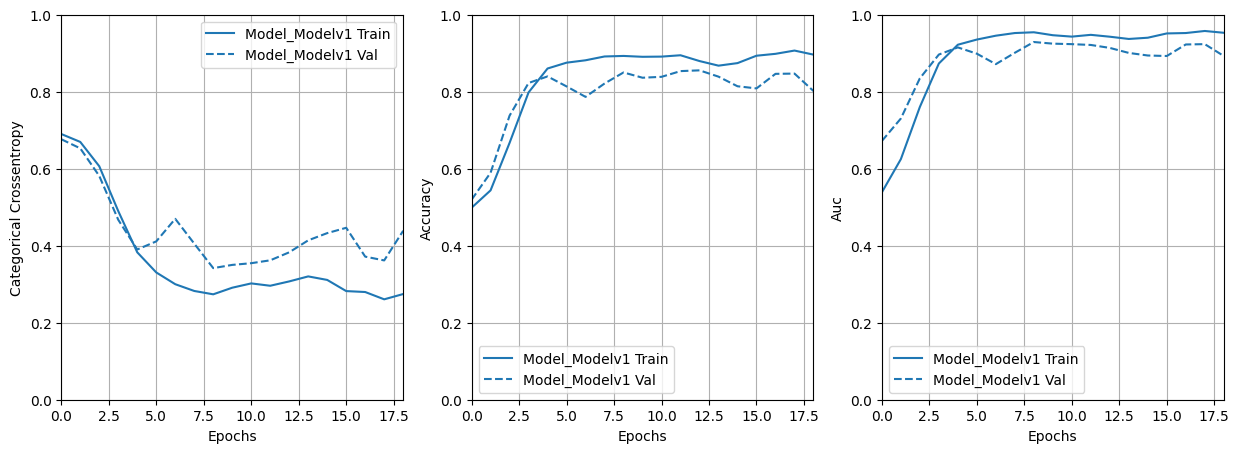

In [40]:
plot_loss_accuracy_cat_x_entropy(model_histories1)
all_models.update(model_histories1)

Found 12637 files belonging to 2 classes.
1/1 [==============================] - 0s 20ms/step


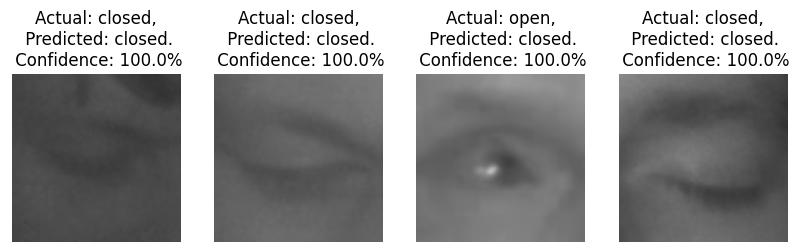

In [41]:
predict_test_images(model1)

In [42]:
model1.save('eyes_model_1.h5')
models_list.append("eyes_model_1.h5")
!ls -lh eyes_model_1.h5

-rw-r--r-- 1 root root 1.3M Apr  9 21:51 eyes_model_1.h5


### **3. CNN model v2 - LeNet_5 (adapted)**
(~30min training, 2 conv layers + averagepooling, relu, 96% Test Accuracy and F1-Score)

In [43]:
#lenet input shape is 32x32 and output is 10 classes for handwritten number recognition
model2 = keras.Sequential()
model2.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(86,86,3)))
model2.add(layers.AveragePooling2D())
model2.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
model2.add(layers.AveragePooling2D())
model2.add(layers.Flatten())
model2.add(layers.Dense(120, activation='relu'))
model2.add(layers.Dense(84, activation='relu')) 
model2.add(layers.Dense(2, activation='softmax')) # 2 or 10 neurons?

In [44]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 84, 84, 6)         168       
                                                                 
 average_pooling2d (AverageP  (None, 42, 42, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 20, 20, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [45]:
model_histories2 = {}
model_histories2['model_Modelv2'] = compile_and_fit(model2,'model_Modelv2', 
                                                            train_generator, 
                                                            validation_generator,
                                                            loss= None, 
                                                            metrics=None, 
                                                            optimizer=None, 
                                                            max_epochs=epochs)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 84, 84, 6)         168       
                                                                 
 average_pooling2d (AverageP  (None, 42, 42, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 20, 20, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_3 (Dense)             (None, 120)              

395/395 [==============================] - 7s 17ms/step - loss: 0.3293 - categorical_crossentropy: 0.3293 - accuracy: 0.8667 - auc: 0.9356
Test set loss                    : 0.3293
Test set categorical_crossentropy: 0.3293
Test set accuracy                : 0.8667
Test set auc                     : 0.9356
395/395 [==============================] - 7s 17ms/step
Classification Report:
              precision    recall  f1-score   support

      closed       0.93      0.79      0.85      6268
        open       0.82      0.95      0.88      6369

    accuracy                           0.87     12637
   macro avg       0.88      0.87      0.87     12637
weighted avg       0.88      0.87      0.87     12637


Confusion Matrix:


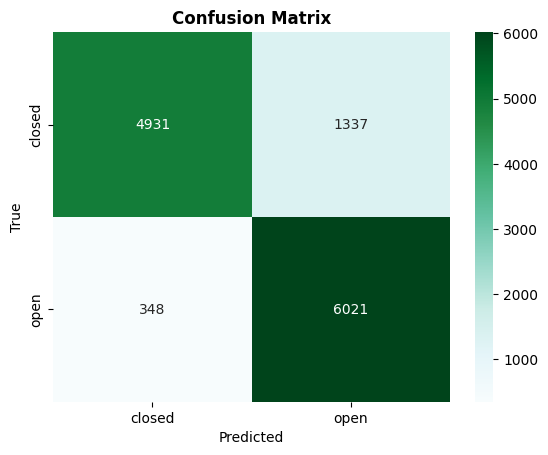

0

In [46]:
evaluate_and_predict(model2, test_generator)

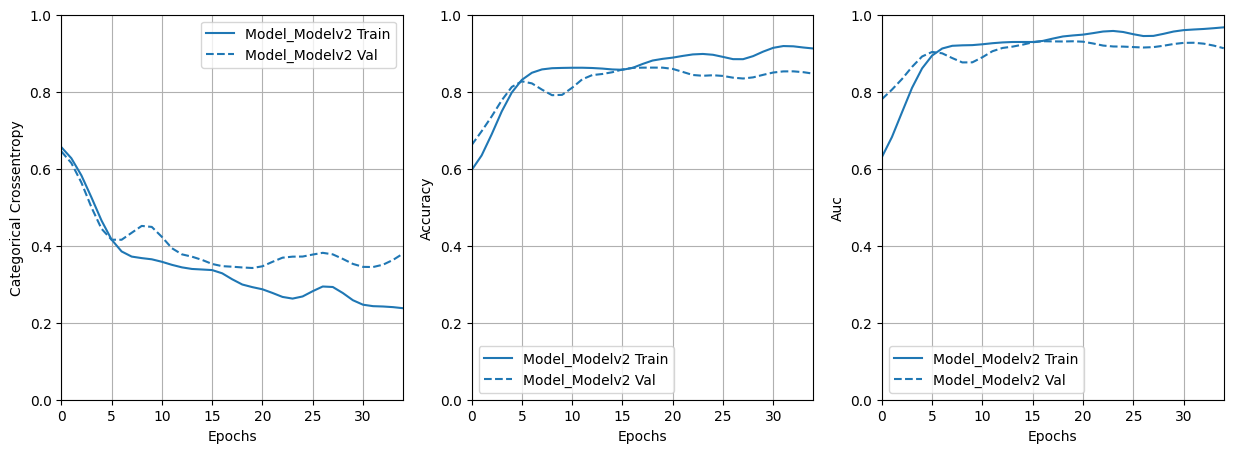

In [47]:
plot_loss_accuracy_cat_x_entropy(model_histories2)
all_models.update(model_histories2)

Found 12637 files belonging to 2 classes.
1/1 [==============================] - 0s 19ms/step


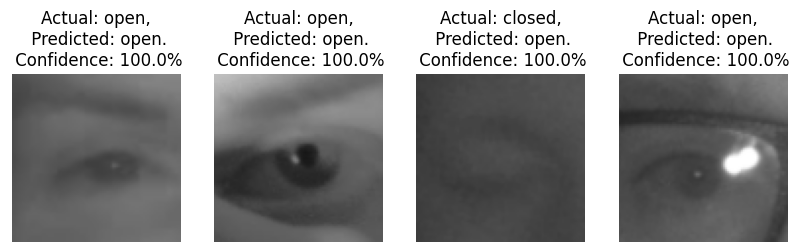

In [48]:
predict_test_images(model2)

In [49]:
model2.save('eyes_model_2.h5')
models_list.append('eyes_model_2.h5')
!ls -lh eyes_model_1.h5

-rw-r--r-- 1 root root 1.3M Apr  9 21:51 eyes_model_1.h5


##**4. CNN - Base Model v3.0**
(~45min training, multiple conv layers + maxpooling + batchnorm + dropout, relu, early stopping, learning rate optimization, 98% Test Accuracy + F1Score)

In [50]:

cnn_model3 = Sequential()
cnn_model3.add(Conv2D(32, kernel_size =(3,3), activation='relu', padding = 'same', input_shape = (86, 86, 3)))
cnn_model3.add(BatchNormalization())
cnn_model3.add(Conv2D(32, kernel_size =(3,3), activation='relu', padding = 'same'))
cnn_model3.add(BatchNormalization())
cnn_model3.add(MaxPooling2D(pool_size=(2,2)))
cnn_model3.add(Dropout(0.2))
cnn_model3.add(Conv2D(64, kernel_size =(3,3), activation='relu', padding = 'same'))
cnn_model3.add(BatchNormalization())
cnn_model3.add(Conv2D(64, kernel_size =(3,3), activation='relu', padding = 'same'))
cnn_model3.add(BatchNormalization())
cnn_model3.add(MaxPooling2D(pool_size=(2,2)))
cnn_model3.add(Dropout(0.2))
cnn_model3.add(Flatten())
cnn_model3.add(Dense(64, activation='relu'))
cnn_model3.add(BatchNormalization())
cnn_model3.add(Dropout(0.2))
cnn_model3.add(Dense(64, activation='relu'))
cnn_model3.add(BatchNormalization())
cnn_model3.add(Dropout(0.2))
cnn_model3.add(Dense(2, activation='softmax'))

In [51]:
model_histories3 = {}
model_histories3['model_Modelv3'] = compile_and_fit(cnn_model3,'model_Modelv3', 
                                                            train_generator, 
                                                            validation_generator,
                                                            loss= None, 
                                                            metrics= None, 
                                                            optimizer=None, 
                                                            max_epochs=epochs)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 86, 86, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 86, 86, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 86, 86, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 86, 86, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                      

395/395 [==============================] - 7s 18ms/step - loss: 0.6967 - categorical_crossentropy: 0.6967 - accuracy: 0.5308 - auc: 0.5138
Test set loss                    : 0.6967
Test set categorical_crossentropy: 0.6967
Test set accuracy                : 0.5308
Test set auc                     : 0.5138
395/395 [==============================] - 7s 17ms/step
Classification Report:
              precision    recall  f1-score   support

      closed       0.51      0.97      0.67      6268
        open       0.75      0.10      0.18      6369

    accuracy                           0.53     12637
   macro avg       0.63      0.53      0.43     12637
weighted avg       0.64      0.53      0.42     12637


Confusion Matrix:


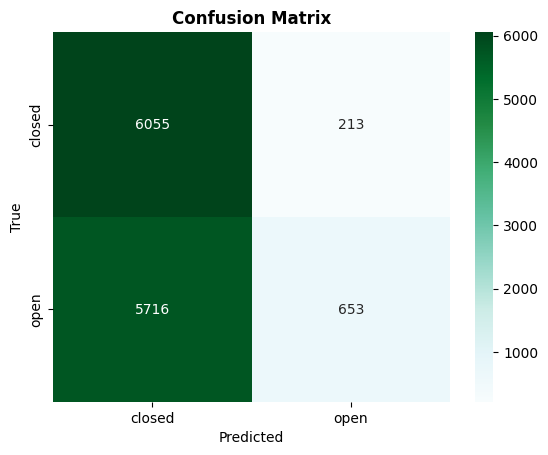

0

In [52]:
evaluate_and_predict(cnn_model3, test_generator)

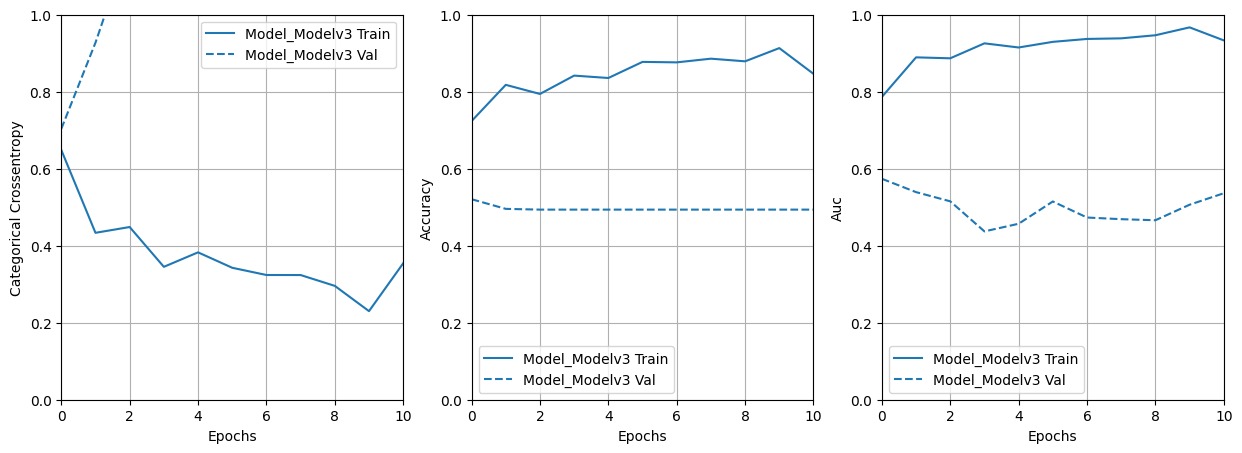

In [53]:
plot_loss_accuracy_cat_x_entropy(model_histories3)
all_models.update(model_histories3)

Found 12637 files belonging to 2 classes.
1/1 [==============================] - 0s 19ms/step


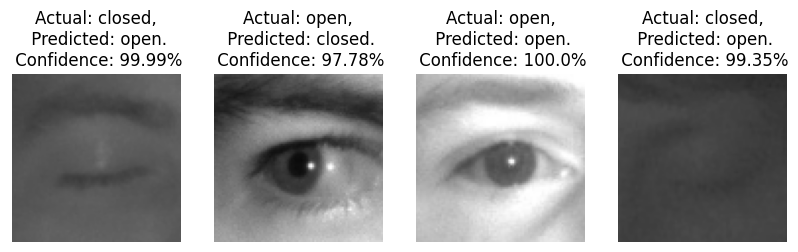

In [54]:
predict_test_images(cnn_model3)

In [55]:
cnn_model3.save('eyes_model_3.h5')
models_list.append('eyes_model_3.h5')
!ls -lh eyes_model_3.h5

-rw-r--r-- 1 root root 22M Apr  9 22:12 eyes_model_3.h5


### **5.CNN - EfficientNetB5 Transfer Learning**

In [56]:
base_model = efn.EfficientNetB5(input_shape = (86, 86, 3), include_top = False, weights = 'imagenet')

115515256/115515256 [==============================] - 6s 0us/step


In [57]:
base_model.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 86, 86, 3)]  0           []                               
                                                                                                  
 stem_conv (Conv2D)             (None, 43, 43, 48)   1296        ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 43, 43, 48)   192         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 43, 43, 48)   0           ['stem_bn[0][0]']                
                                                                                    

In [58]:
for layer in base_model.layers:
    layer.trainable = False

In [59]:
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)

In [60]:
predictions = Dense(2, activation="softmax")(x)
model_final = Model(inputs = base_model.input, outputs = predictions)

In [61]:
# model_final.summary()

In [62]:
model_histories4 = {}
optimizer = RMSprop(learning_rate=0.0001, weight_decay=1e-6)
model_histories4['model_final_eff'] = compile_and_fit(model_final,'model_final_eff', 
                                                            train_generator, 
                                                            validation_generator,
                                                            loss= None, 
                                                            metrics= None, 
                                                            optimizer=optimizer, 
                                                            max_epochs=epochs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 86, 86, 3)]  0           []                               
                                                                                                  
 stem_conv (Conv2D)             (None, 43, 43, 48)   1296        ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 43, 43, 48)   192         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 43, 43, 48)   0           ['stem_bn[0][0]']                
                                                                                              

10/10 [==============================] - ETA: 0s - loss: 0.8191 - categorical_crossentropy: 0.8191 - accuracy: 0.5813 - auc: 0.5861
Epoch: 0, accuracy:0.5813,  auc:0.5861,  categorical_crossentropy:0.8191,  loss:0.8191,  val_accuracy:0.6306,  val_auc:0.6504,  val_categorical_crossentropy:0.6783,  val_loss:0.6783,  
10/10 [==============================] - 49s 4s/step - loss: 0.8191 - categorical_crossentropy: 0.8191 - accuracy: 0.5813 - auc: 0.5861 - val_loss: 0.6783 - val_categorical_crossentropy: 0.6783 - val_accuracy: 0.6306 - val_auc: 0.6504 - lr: 1.0000e-04
Epoch 2/50
10/10 [==============================] - 27s 3s/step - loss: 0.6396 - categorical_crossentropy: 0.6396 - accuracy: 0.6969 - auc: 0.7220 - val_loss: 0.6004 - val_categorical_crossentropy: 0.6004 - val_accuracy: 0.7004 - val_auc: 0.7420 - lr: 1.0000e-04
Epoch 3/50
10/10 [==============================] - 28s 3s/step - loss: 0.5507 - categorical_crossentropy: 0.5507 - accuracy: 0.7469 - auc: 0.7989 - val_loss: 0.5769 - 

395/395 [==============================] - 8s 20ms/step - loss: 0.2188 - categorical_crossentropy: 0.2188 - accuracy: 0.9132 - auc: 0.9712
Test set loss                    : 0.2188
Test set categorical_crossentropy: 0.2188
Test set accuracy                : 0.9132
Test set auc                     : 0.9712
395/395 [==============================] - 11s 19ms/step
Classification Report:
              precision    recall  f1-score   support

      closed       0.93      0.89      0.91      6268
        open       0.89      0.94      0.92      6369

    accuracy                           0.91     12637
   macro avg       0.91      0.91      0.91     12637
weighted avg       0.91      0.91      0.91     12637


Confusion Matrix:


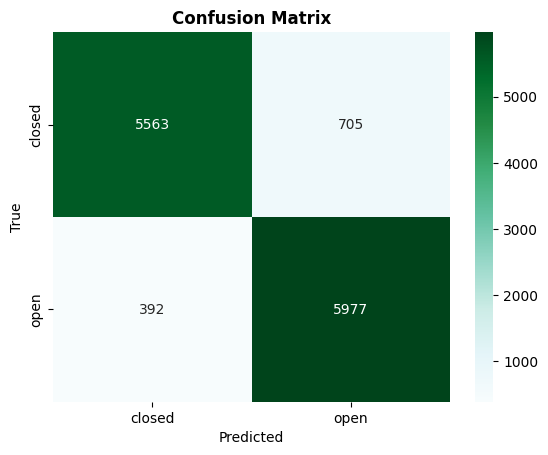

0

In [63]:
evaluate_and_predict(model_final, test_generator)

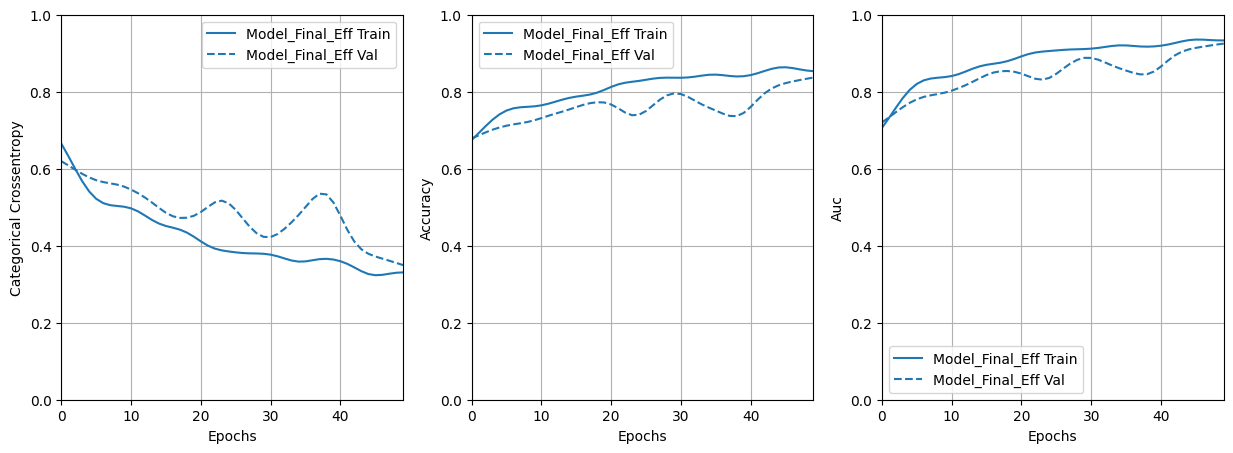

In [64]:
plot_loss_accuracy_cat_x_entropy(model_histories4)
all_models.update(model_histories4)

Found 12637 files belonging to 2 classes.
1/1 [==============================] - 0s 33ms/step


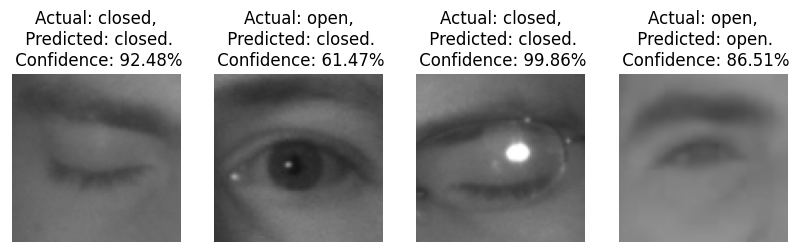

In [65]:
predict_test_images(model_final)

In [66]:
model_final.save('eyes_model_5.h5')
models_list.append('eyes_model_5.h5')
!ls -lh eyes_model_5.h5

-rw-r--r-- 1 root root 120M Apr  9 22:36 eyes_model_5.h5


### VGG19

In [81]:
#VGG19
vggmodel19 = VGG19(weights='imagenet', include_top=False,input_tensor=Input(shape=(86,86,3)))
vggmodel19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 86, 86, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 86, 86, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 86, 86, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 43, 43, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 43, 43, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 43, 43, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 21, 21, 128)       0     

In [82]:
#Training to False
for layers in (vggmodel19.layers):
    print(layers.name)
    layers.trainable = False
vggmodel19.summary()

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 86, 86, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 86, 86, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 86, 86, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 43, 43, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 43, 43, 128) 

In [83]:
inputs = keras.Input(shape=(86, 86, 3))
X = vggmodel19(inputs, training=False)
X = keras.layers.GlobalAveragePooling2D()(X)
X = keras.layers.Dropout(0.2)(X)
outputs = Dense(2, activation='softmax')(X)
model_final19 = Model(inputs, outputs)
model_final19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 86, 86, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
___________________________________________

### Train the Top Layer

In [84]:
size_histories5 = {}
size_histories5['model_final19'] = compile_and_fit(model_final19,'model_final19', 
                                                  train_generator, validation_generator, 
                                                  loss= None, 
                                                  metrics= None, 
                                                  optimizer=None, 
                                                  max_epochs=epochs)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 86, 86, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
___________________________________________

395/395 [==============================] - 7s 18ms/step - loss: 0.5524 - categorical_crossentropy: 0.5524 - accuracy: 0.7112 - auc: 0.8044
Test set loss                    : 0.5524
Test set categorical_crossentropy: 0.5524
Test set accuracy                : 0.7112
Test set auc                     : 0.8044
395/395 [==============================] - 7s 17ms/step
Classification Report:
              precision    recall  f1-score   support

      closed       0.66      0.87      0.75      6268
        open       0.82      0.55      0.66      6369

    accuracy                           0.71     12637
   macro avg       0.74      0.71      0.70     12637
weighted avg       0.74      0.71      0.70     12637


Confusion Matrix:


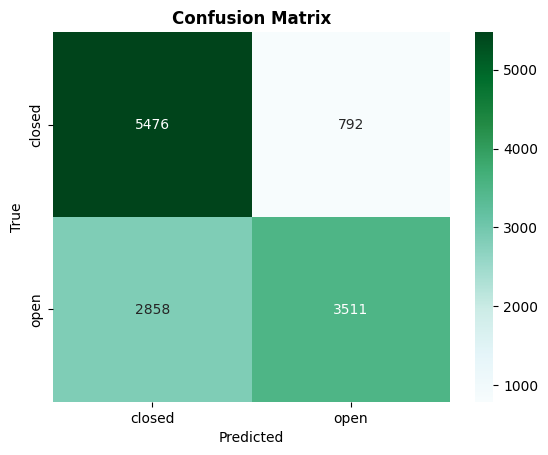

0

In [85]:
evaluate_and_predict(model_final19, test_generator)

0

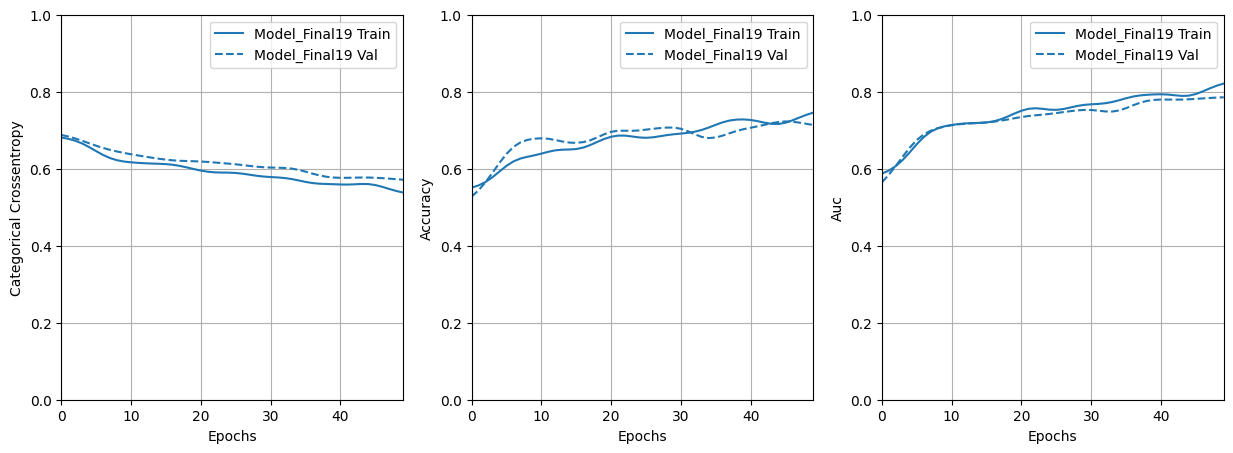

In [86]:
plot_loss_accuracy_cat_x_entropy(size_histories5)

### fine-tuning of the entire model

In [87]:
# Unfreeze the base model
vggmodel19.trainable = True
model_final19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 86, 86, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 20,025,410
Trainable params: 20,025,410
Non-trainable params: 0
_______________________________________________

In [88]:
size_histories5['model_final19-finetuned'] = compile_and_fit(model_final19,'model_final19-finetuned', 
                                                             train_generator, 
                                                             validation_generator,
                                                             loss = None , 
                                                             metrics = None, 
                                                             optimizer=keras.optimizers.Adam(1e-5), 
                                                             max_epochs=10)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 86, 86, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 20,025,410
Trainable params: 20,025,410
Non-trainable params: 0
_______________________________________________

395/395 [==============================] - 7s 18ms/step - loss: 0.1450 - categorical_crossentropy: 0.1450 - accuracy: 0.9418 - auc: 0.9875
Test set loss                    : 0.1450
Test set categorical_crossentropy: 0.1450
Test set accuracy                : 0.9418
Test set auc                     : 0.9875
395/395 [==============================] - 7s 17ms/step
Classification Report:
              precision    recall  f1-score   support

      closed       0.90      0.99      0.94      6268
        open       0.99      0.89      0.94      6369

    accuracy                           0.94     12637
   macro avg       0.95      0.94      0.94     12637
weighted avg       0.95      0.94      0.94     12637


Confusion Matrix:


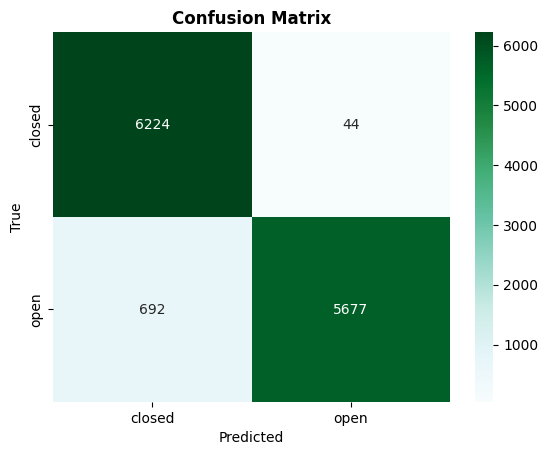

0

In [89]:
evaluate_and_predict(model_final19, test_generator)

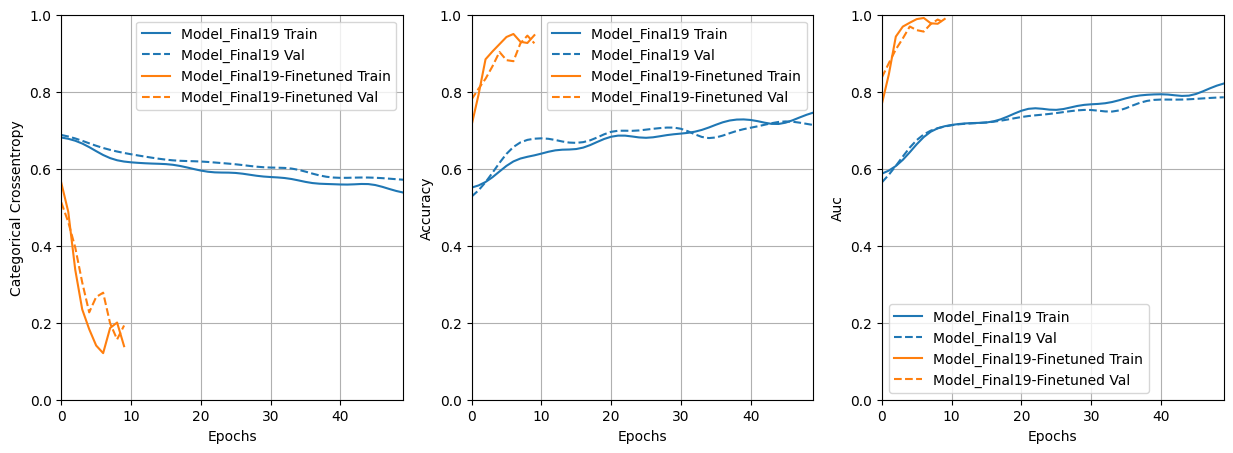

In [90]:
plot_loss_accuracy_cat_x_entropy(size_histories5)
all_models.update(size_histories5)

Found 12637 files belonging to 2 classes.
1/1 [==============================] - 0s 21ms/step


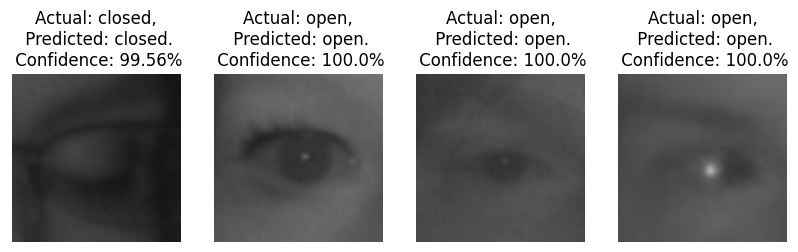

In [91]:
predict_test_images(model_final19)

In [92]:
model_final19.save('eyes_model_6.h5')
models_list.append('eyes_model_6.h5')
!ls -lh eyes_model_6.h5

-rw-r--r-- 1 root root 230M Apr 10 00:07 eyes_model_6.h5


### Comparing All Models

0

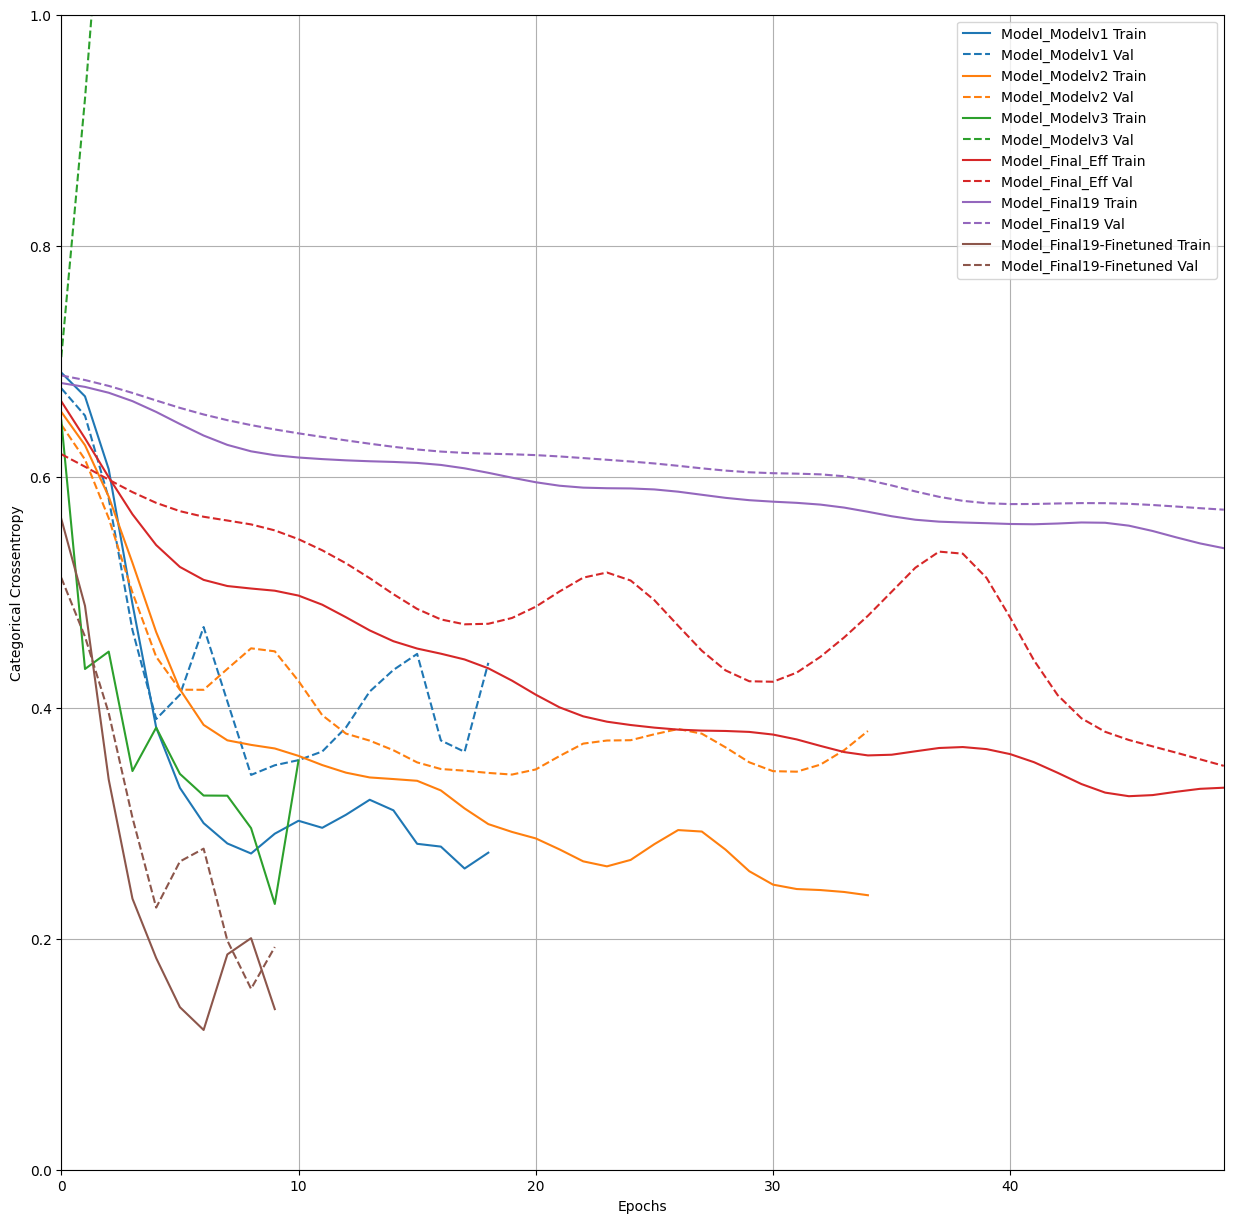

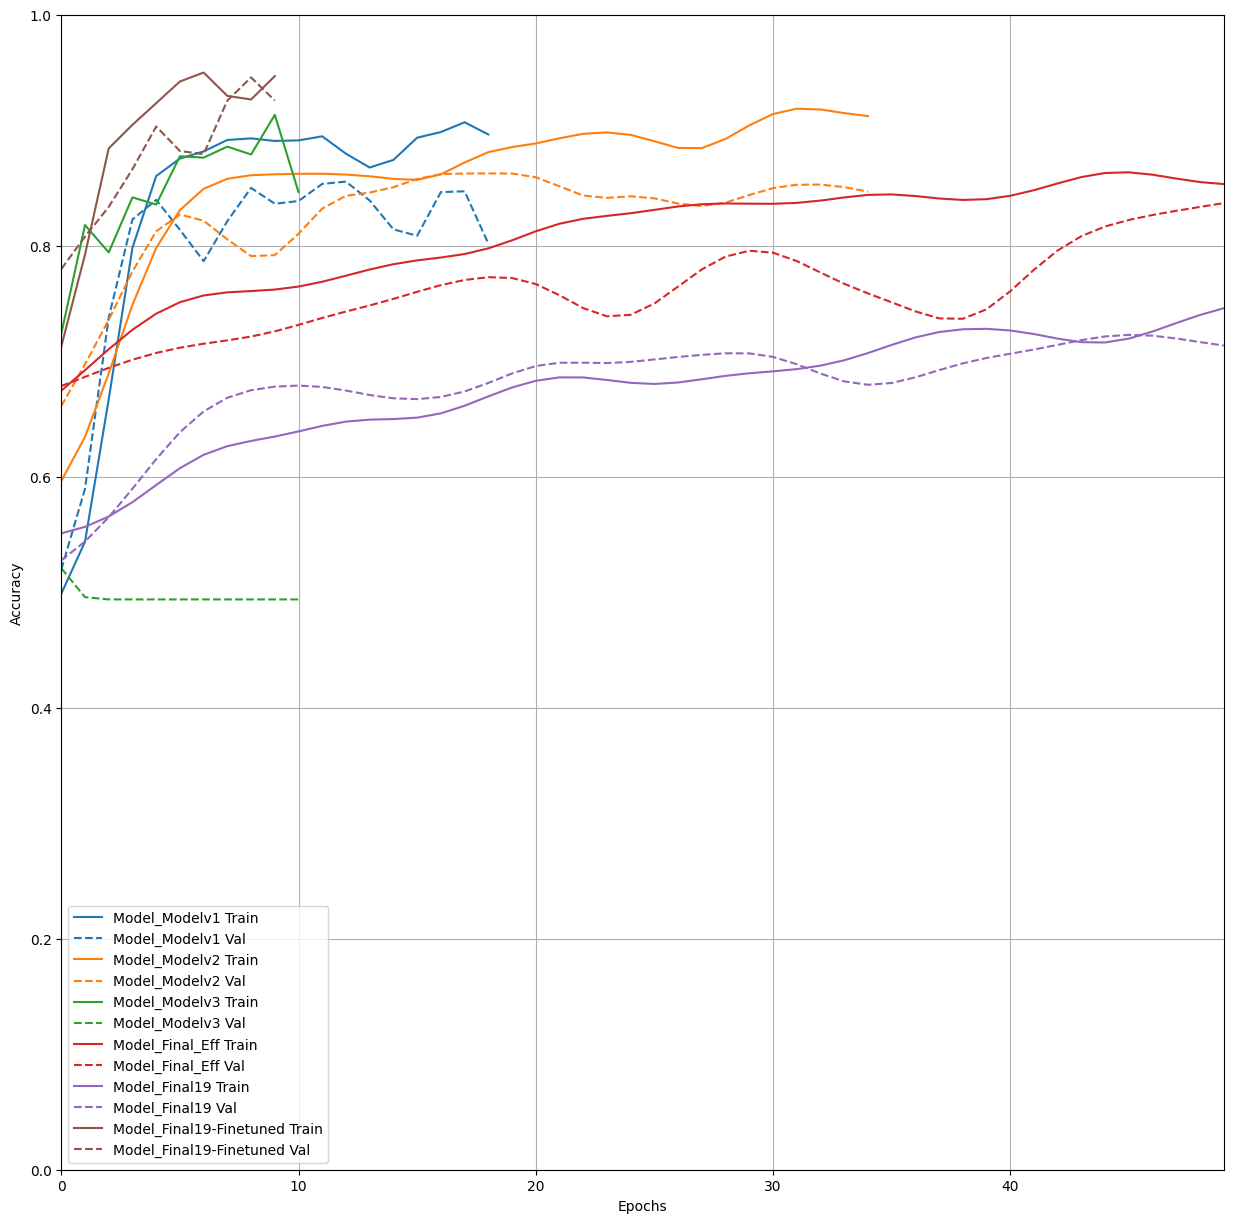

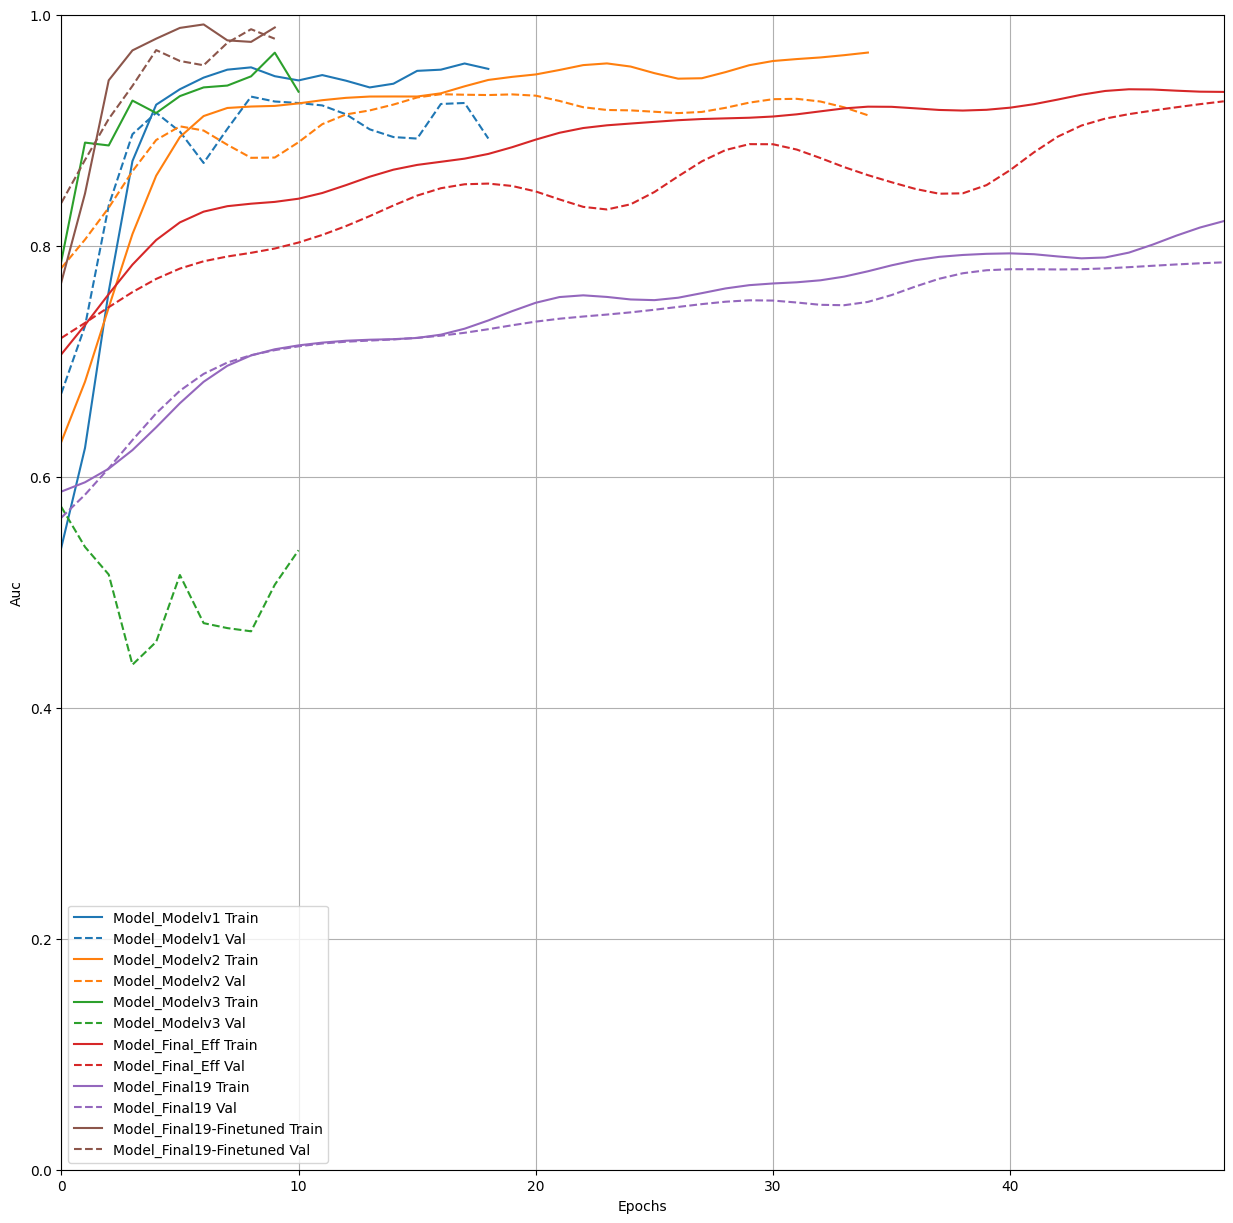

In [93]:
plot_loss_accuracy_cat_x_entropy_all(all_models)

### Compare the model performance:

In [94]:
for saved_mdl in models_list:
  print(saved_mdl)
  test_saved_models(saved_mdl)

eyes_model_0.h5

-------Begin-------
| ID | GPU | MEM |
------------------
|  0 |  0% | 13% |
395/395 [==============================] - 7s 17ms/step
| ID | GPU | MEM |
------------------
|  0 |  0% | 13% |
-------Time taken to process images: 7.038079109001046
Classification Report:
              precision    recall  f1-score   support

      closed       0.80      0.96      0.87      6268
        open       0.95      0.77      0.85      6369

    accuracy                           0.86     12637
   macro avg       0.88      0.86      0.86     12637
weighted avg       0.88      0.86      0.86     12637


Confusion Matrix:
[[6007  261]
 [1457 4912]]

-------End-------
eyes_model_1.h5

-------Begin-------
| ID | GPU | MEM |
------------------
|  0 |  0% | 13% |
395/395 [==============================] - 7s 17ms/step
| ID | GPU | MEM |
------------------
|  0 |  1% | 13% |
-------Time taken to process images: 7.212997254999209
Classification Report:
              precision    recall  f1-